In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
%load_ext google.cloud.bigquery
from google.cloud import bigquery

client=bigquery.Client()
project_id = "som-nero-phi-jonc101"

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


# Data preprocessing mainly used to impute null values, scale parameters, and remove outliers

#### Load all data

In [5]:
# demo
table_id_final_base_demo =  f"{project_id}.blood_culture_stewardship_sandy_2024.enriched_label_filtered_adult_only_analysis_cohort"

final_base_demo = client.query(f"SELECT * FROM `{table_id_final_base_demo}`").to_dataframe()
# labs
table_id_final_base_labs_lda_ua = f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_labs_without_cpr_or_pct_lda_encouter_level_adult"
final_base_labs_ua_lda= client.query(f"SELECT * FROM `{table_id_final_base_labs_lda_ua}`").to_dataframe()
# vitals
table_id_final_base_vitals =f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_vitals_adult_encounter_level"
final_base_vitals= client.query(f"SELECT * FROM `{table_id_final_base_vitals}`").to_dataframe()

table_id_final_labs_cr_only = f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_labs_cr_only_encounter_level_adult"
final_labs_cr_only = client.query(f"SELECT * FROM `{table_id_final_labs_cr_only}`").to_dataframe()



In [6]:
# Alternative: Using functools.reduce to merge multiple dataframes at once
from functools import reduce

# Define merge keys
key_cols = ["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", "blood_culture_order_datetime_utc"]

# List of dataframes to merge
dfs_to_merge = [final_base_demo, final_base_labs_ua_lda, final_base_vitals, final_labs_cr_only]

# Merge all dataframes
all_features_df = reduce(
    lambda left, right: pd.merge(left, right, on=key_cols, how="inner"),
    dfs_to_merge
)

print(f"Shape of merged features: {all_features_df.shape}")
print(f"Number of rows: {len(all_features_df)}")
all_features_df.head()


Shape of merged features: (101836, 102)
Number of rows: 101836


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,blood_culture_order_datetime_utc,order_year,ordering_mode,department_id,description,order_status,lab_status,abnormal_yn,department_name,ed_arrival_datetime_utc,ord_value,comment,organisms,n_organisms,n_potential_contam_orgs,n_non_potential_orgs,n_cons_organism,total_sets_in_encounter,has_sensitivity,cons_sets_in_encounter,potential_contam_sets_same_org,set_promoted_from_potential_contam,set_level_label,final_label,encounter_promoted_from_potential_contam,gender,bmi,age,min_wbc,max_wbc,avg_wbc,median_wbc,min_neutrophils,max_neutrophils,avg_neutrophils,median_neutrophils,min_anc,max_anc,avg_anc,median_anc,min_lymphocytes,max_lymphocytes,avg_lymphocytes,median_lymphocytes,min_alc,max_alc,avg_alc,median_alc,min_hgb,max_hgb,avg_hgb,median_hgb,min_plt,max_plt,avg_plt,median_plt,min_glucose,max_glucose,avg_glucose,median_glucose,min_lactate,max_lactate,avg_lactate,median_lactate,has_any_line,temp_min_c,temp_avg_c,temp_max_c,temp_median_c,temp_mode_c,resp_min,resp_avg,resp_max,resp_median,resp_mode,hr_min,hr_avg,hr_max,hr_median,hr_mode,sysbp_min,sysbp_avg,sysbp_max,sysbp_median,sysbp_mode,diabp_min,diabp_avg,diabp_max,diabp_median,diabp_mode,spo2_min,spo2_avg,spo2_max,spo2_median,spo2_mode,min_cr,max_cr,avg_cr,median_cr
0,JC1000129,131354606122,876959986,2023-04-23 22:44:00+00:00,2023,Inpatient,110100019,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Final result,Y,ADULT EMERGENCY DEPARTMENT,2023-04-23 22:41:00+00:00,Both Aerobic bottles: Non lactose fermenting G...,"for identification and susceptibility testing,...",None,<NA>,<NA>,<NA>,<NA>,2,False,0,<NA>,0,negative,positive,0,Male,22.45,87,16.9,16.9,16.9,16.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.8,0.8,0.8,0.14,0.14,0.14,0.14,11.8,11.8,11.8,11.8,194.0,194.0,194.0,194.0,165.0,165.0,165.00,165.0,3.56,6.44,5.05,4.42,0,37.000000,37.000000,37.000000,37.000000,37.0,22.0,26.000000,28.0,28.0,28.0,70.0,74.250000,77.0,74.0,70.0,85.0,106.0,117.0,116.0,85.0,43.0,50.666667,58.0,51.0,43.0,97.0,98.333333,100.0,98.0,97.0,2.83,2.83,2.83,2.83
1,JC1000159,131233687107,528085198,2017-06-25 16:42:00+00:00,2017,Inpatient,2001002,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Edited Result - FINAL,Y,PEDIATRIC EMERGENCY DEPARTMENT,2017-06-25 16:38:00+00:00,Both Aerobic bottles: Escherichia coli,Not all antibiotics for which susceptibility r...,ESCHERICHIA COLI,1,0,1,0,2,True,0,0,0,positive,positive,0,Female,26.61,94,15.4,15.4,15.4,15.4,91.5,91.5,91.5,91.5,14.10,14.10,14.10,14.10,3.1,3.1,3.1,3.1,0.48,0.48,0.48,0.48,9.2,9.2,9.2,9.2,109.0,109.0,109.0,109.0,155.0,155.0,155.00,155.0,1.50,1.70,1.60,1.50,0,37.500000,38.055556,38.611111,37.500000,37.5,24.0,26.000000,28.0,24.0,24.0,95.0,95.000000,95.0,95.0,95.0,161.0,162.0,163.0,161.0,161.0,66.0,70.500000,75.0,66.0,66.0,92.0,94.000000,96.0,92.0,92.0,0.87,0.87,0.87,0.87
2,JC1000413,131018846539,401262600,2012-04-20 05:09:00+00:00,2012,Inpatient,2001002,BLOOD CULTURE (AEROBIC & ANAEROBIC BOTTLES),Completed,Final result,None,PEDIATRIC EMERGENCY DEPARTMENT,2012-04-20 04:39:00+00:00,BLOOD; right antecubital; 05262012 FINAL,NO GROWTH 6 DAYS\nPerformed at Stanford Clinic...,None,<NA>,<NA>,<NA>,<NA>,1,False,0,<NA>,0,negative,negative,0,Male,18.73,92,8.9,8.9,8.9,8.9,NaN,NaN,NaN,NaN,6.61,6.61,6.61,6.61,12.8,12.8,12.8,12.8,1.14,1.14,1.14,1.14,12.0,12.0,12.0,12.0,264.0,264.0,264.0,264.0,125.0,125.0,125.00,125.0,0.70,0.70,0.70,0.70,0,36.444444,36.444444,36.444444,36.444444,36.4,18.0,20.000000,22.0,18.0,18.0,91.0,96.500000,102.0,91.0,91.0,128.0,128.0,128.0,128.0,128.0,70.0,70.000000,70.0,70.0,70.0,97.0,98.000000,99.0,97.0,97.0,1.90,1.90,1.90,1.90
3,JC1000492,131356383252,883656152,2023-07-11 00:58:00+00:00,2023,Inpatient,110100019,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Final result,None,ADULT EMERGENCY DEPARTMENT,2023-07-10 21:21:00+00:00,No growth at 4 days,None,None,<NA>,<NA>,<NA>,<NA>,2,False,0,<NA>,0,negative,negative,0,Male,17.50,78,8.2,8.2,8.2,8.2,74.9,74.9,74.9,74.9,6.12,6.12,6.12,6.12,15.7,15.7,15.7,15.7,1.28,1.28,1.28,1.

In [7]:
all_features_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,blood_culture_order_datetime_utc,order_year,ordering_mode,department_id,description,order_status,lab_status,abnormal_yn,department_name,ed_arrival_datetime_utc,ord_value,comment,organisms,n_organisms,n_potential_contam_orgs,n_non_potential_orgs,n_cons_organism,total_sets_in_encounter,has_sensitivity,cons_sets_in_encounter,potential_contam_sets_same_org,set_promoted_from_potential_contam,set_level_label,final_label,encounter_promoted_from_potential_contam,gender,bmi,age,min_wbc,max_wbc,avg_wbc,median_wbc,min_neutrophils,max_neutrophils,avg_neutrophils,median_neutrophils,min_anc,max_anc,avg_anc,median_anc,min_lymphocytes,max_lymphocytes,avg_lymphocytes,median_lymphocytes,min_alc,max_alc,avg_alc,median_alc,min_hgb,max_hgb,avg_hgb,median_hgb,min_plt,max_plt,avg_plt,median_plt,min_glucose,max_glucose,avg_glucose,median_glucose,min_lactate,max_lactate,avg_lactate,median_lactate,has_any_line,temp_min_c,temp_avg_c,temp_max_c,temp_median_c,temp_mode_c,resp_min,resp_avg,resp_max,resp_median,resp_mode,hr_min,hr_avg,hr_max,hr_median,hr_mode,sysbp_min,sysbp_avg,sysbp_max,sysbp_median,sysbp_mode,diabp_min,diabp_avg,diabp_max,diabp_median,diabp_mode,spo2_min,spo2_avg,spo2_max,spo2_median,spo2_mode,min_cr,max_cr,avg_cr,median_cr
0,JC1000129,131354606122,876959986,2023-04-23 22:44:00+00:00,2023,Inpatient,110100019,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Final result,Y,ADULT EMERGENCY DEPARTMENT,2023-04-23 22:41:00+00:00,Both Aerobic bottles: Non lactose fermenting G...,"for identification and susceptibility testing,...",None,<NA>,<NA>,<NA>,<NA>,2,False,0,<NA>,0,negative,positive,0,Male,22.45,87,16.9,16.9,16.90,16.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.8,0.8,0.8,0.14,0.14,0.14,0.14,11.8,11.8,11.80,11.8,194.0,194.0,194.0,194.0,165.0,165.0,165.00,165.0,3.56,6.44,5.05,4.42,0,37.000000,37.000000,37.000000,37.000000,37.0,22.0,26.000000,28.0,28.0,28.0,70.0,74.250000,77.0,74.0,70.0,85.0,106.000000,117.0,116.0,85.0,43.0,50.666667,58.0,51.0,43.0,97.0,98.333333,100.0,98.0,97.0,2.83,2.83,2.83,2.83
1,JC1000159,131233687107,528085198,2017-06-25 16:42:00+00:00,2017,Inpatient,2001002,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Edited Result - FINAL,Y,PEDIATRIC EMERGENCY DEPARTMENT,2017-06-25 16:38:00+00:00,Both Aerobic bottles: Escherichia coli,Not all antibiotics for which susceptibility r...,ESCHERICHIA COLI,1,0,1,0,2,True,0,0,0,positive,positive,0,Female,26.61,94,15.4,15.4,15.40,15.4,91.5,91.5,91.5,91.5,14.10,14.10,14.10,14.10,3.1,3.1,3.1,3.1,0.48,0.48,0.48,0.48,9.2,9.2,9.20,9.2,109.0,109.0,109.0,109.0,155.0,155.0,155.00,155.0,1.50,1.70,1.60,1.50,0,37.500000,38.055556,38.611111,37.500000,37.5,24.0,26.000000,28.0,24.0,24.0,95.0,95.000000,95.0,95.0,95.0,161.0,162.000000,163.0,161.0,161.0,66.0,70.500000,75.0,66.0,66.0,92.0,94.000000,96.0,92.0,92.0,0.87,0.87,0.87,0.87
2,JC1000413,131018846539,401262600,2012-04-20 05:09:00+00:00,2012,Inpatient,2001002,BLOOD CULTURE (AEROBIC & ANAEROBIC BOTTLES),Completed,Final result,None,PEDIATRIC EMERGENCY DEPARTMENT,2012-04-20 04:39:00+00:00,BLOOD; right antecubital; 05262012 FINAL,NO GROWTH 6 DAYS\nPerformed at Stanford Clinic...,None,<NA>,<NA>,<NA>,<NA>,1,False,0,<NA>,0,negative,negative,0,Male,18.73,92,8.9,8.9,8.90,8.9,NaN,NaN,NaN,NaN,6.61,6.61,6.61,6.61,12.8,12.8,12.8,12.8,1.14,1.14,1.14,1.14,12.0,12.0,12.00,12.0,264.0,264.0,264.0,264.0,125.0,125.0,125.00,125.0,0.70,0.70,0.70,0.70,0,36.444444,36.444444,36.444444,36.444444,36.4,18.0,20.000000,22.0,18.0,18.0,91.0,96.500000,102.0,91.0,91.0,128.0,128.000000,128.0,128.0,128.0,70.0,70.000000,70.0,70.0,70.0,97.0,98.000000,99.0,97.0,97.0,1.90,1.90,1.90,1.90
3,JC1000492,131356383252,883656152,2023-07-11 00:58:00+00:00,2023,Inpatient,110100019,BLOOD CULTURE (2 AEROBIC BOTTLES),Completed,Final result,None,ADULT EMERGENCY DEPARTMENT,2023-07-10 21:21:00+00:00,No growth at 4 days,None,None,<NA>,<NA>,<NA>,<NA>,2,False,0,<NA>,0,negative,negative,0,Male,17.50,78,8.2,8.2,8.20,8.2,74.9,74.9,74.9,74.9,6.12,6.12,6.12,6.12,15.7,15.7,15.7,

## data split

### split into train, val, test (with ~70%,~15%,~15%)
### use longitudinal split
### train: start - 2023 (Exclusive)
### val: 2023-2024 (exclusive)
### test: 2024-now (inclusive)
### the prevalence is about 5% for all data split

In [12]:
all_features_df["label"] = (all_features_df["final_label"] == "positive").astype(int)

In [ ]:

print(f"total number of rows: {all_features_df.shape[0]}")
train_data = all_features_df[all_features_df['order_year'] < 2023]
val_data = all_features_df[(all_features_df['order_year'] >= 2023) & (all_features_df['order_year'] < 2024)]
test_data = all_features_df[all_features_df['order_year'] >= 2024]

print(f"Train data shape: {train_data.shape} and is {train_data.shape[0] / all_features_df.shape[0] * 100}% of all data")
print(f"Val data shape: {val_data.shape} and is {val_data.shape[0] / all_features_df.shape[0] * 100}% of all data")
print(f"Test data shape: {test_data.shape} and is {test_data.shape[0] / all_features_df.shape[0] * 100}% of all data")

total number of rows: 101836
Train data shape: (73264, 103) and is 71.94312423897247% of all data
Val data shape: (13417, 103) and is 13.175105070898308% of all data
Test data shape: (15155, 103) and is 14.881770690129228% of all data


In [15]:
# prevalence of blood culture positive
print(f"prevalence of blood culture positive in all data: {all_features_df['label'].mean() *100}%")
print(f"prevalence of blood culture positive in train data: {train_data['label'].mean() *100}%")
print(f"prevalence of blood culture positive in val data: {val_data['label'].mean() *100}%")
print(f"prevalence of blood culture positive in test data: {test_data['label'].mean() *100}%")

prevalence of blood culture positive in all data: 7.5886719824030795%
prevalence of blood culture positive in train data: 7.853789036907621%
prevalence of blood culture positive in val data: 6.6780949541626295%
prevalence of blood culture positive in test data: 7.113163972286374%


## CATBoost

In [60]:
final_base_labs_ua_lda.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'blood_culture_order_datetime_utc', 'min_wbc', 'max_wbc', 'avg_wbc',
       'median_wbc', 'min_neutrophils', 'max_neutrophils', 'avg_neutrophils',
       'median_neutrophils', 'min_anc', 'max_anc', 'avg_anc', 'median_anc',
       'min_lymphocytes', 'max_lymphocytes', 'avg_lymphocytes',
       'median_lymphocytes', 'min_alc', 'max_alc', 'avg_alc', 'median_alc',
       'min_hgb', 'max_hgb', 'avg_hgb', 'median_hgb', 'min_plt', 'max_plt',
       'avg_plt', 'median_plt', 'min_glucose', 'max_glucose', 'avg_glucose',
       'median_glucose', 'min_lactate', 'max_lactate', 'avg_lactate',
       'median_lactate', 'has_any_line'],
      dtype='object')

In [62]:

# --- define your keys (from your message) ---
label_key = "label"



vital_feature_key = [
    "temp_min_c", "temp_avg_c", "temp_max_c", "temp_median_c", "temp_mode_c",
    "resp_min", "resp_avg", "resp_max", "resp_median", "resp_mode",
    "hr_min", "hr_avg", "hr_max", "hr_median", "hr_mode",
    "sysbp_min", "sysbp_avg", "sysbp_max", "sysbp_median", "sysbp_mode",
    "diabp_min", "diabp_avg", "diabp_max", "diabp_median", "diabp_mode",
    "spo2_min", "spo2_avg", "spo2_max", "spo2_median", "spo2_mode"
]
demo_feature_key = ["gender", "age", "bmi"]

# vital_feature_key = [
#     "temp_max_c", 
#     "resp_max", 
#     "hr_max",
#     "sysbp_min", 
#     "diabp_min",
#     # "spo2_min", 
# ]

# lab_ua_lda_feature_key = [
#     "max_wbc", "max_neutrophils", "max_anc", "min_lymphocytes", "min_alc",
#     "min_hgb", "min_plt", "max_glucose", "max_lactate", 
#     "has_any_line"
# ]
lab_ua_lda_feature_key = ['min_wbc', 'max_wbc', 'avg_wbc',
       'median_wbc', 'min_neutrophils', 'max_neutrophils', 'avg_neutrophils',
       'median_neutrophils', 'min_anc', 'max_anc', 'avg_anc', 'median_anc',
       'min_lymphocytes', 'max_lymphocytes', 'avg_lymphocytes',
       'median_lymphocytes', 'min_alc', 'max_alc', 'avg_alc', 'median_alc',
       'min_hgb', 'max_hgb', 'avg_hgb', 'median_hgb', 'min_plt', 'max_plt',
       'avg_plt', 'median_plt', 'min_glucose', 'max_glucose', 'avg_glucose',
       'median_glucose', 'min_lactate', 'max_lactate', 'avg_lactate',
       'median_lactate', 'has_any_line']
# --- define your categorical columns (no has_any_line here) ---
cat_cols_user = [
    "gender", "has_any_line"
]



# 1) Build final feature list (keep only columns that exist in train_imp)
selected_features = [c for c in (demo_feature_key + vital_feature_key + lab_ua_lda_feature_key)
                     if c in train_data.columns]






X_train_base = train_data[selected_features]
X_val_base   = val_data[selected_features]
X_test_base  = test_data[selected_features]

y_train = train_data[label_key].astype(int).values
y_val   = val_data[label_key].astype(int).values
y_test  = test_data[label_key].astype(int).values


print("✅ Shapes:")
print("   X_train:", X_train_base.shape, " | y_train:", y_train.shape)
print("   X_val  :", X_val_base.shape,   " | y_val  :", y_val.shape)
print("   X_test :", X_test_base.shape,  " | y_test :", y_test.shape)
print("Example features:", list(X_train_base.columns[:12]))


✅ Shapes:
   X_train: (73264, 70)  | y_train: (73264,)
   X_val  : (13417, 70)  | y_val  : (13417,)
   X_test : (15155, 70)  | y_test : (15155,)
Example features: ['gender', 'age', 'bmi', 'temp_min_c', 'temp_avg_c', 'temp_max_c', 'temp_median_c', 'temp_mode_c', 'resp_min', 'resp_avg', 'resp_max', 'resp_median']


# training

In [63]:
from catboost import CatBoostClassifier, Pool
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# --- figure out which categorical columns are actually present in X_* ---
cat_cols = [c for c in cat_cols_user if c in X_train_base.columns]

# indices of categorical columns (CatBoost needs positions, not names)
cat_feature_indices = [X_train_base.columns.get_loc(c) for c in cat_cols]

print("Categorical features actually used:", cat_cols)

# --- Build CatBoost Pool objects ---
train_pool = Pool(
    data=X_train_base,
    label=y_train,
    cat_features=cat_feature_indices
)

val_pool = Pool(
    data=X_val_base,
    label=y_val,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test_base,
    label=y_test,
    cat_features=cat_feature_indices
)


Categorical features actually used: ['gender', 'has_any_line']


In [64]:
# simple positive class weight = N_neg / N_pos
pos_ratio = y_train.mean()
neg_ratio = 1 - pos_ratio
pos_weight = neg_ratio / pos_ratio

class_weights = [1.0, pos_weight]

print(f"Positive class weight ≈ {pos_weight:.2f}")


Positive class weight ≈ 11.73


In [65]:
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6,
    learning_rate=0.05,
    iterations=2000,
    l2_leaf_reg=3.0,
    border_count=128,
    class_weights=class_weights,
    random_seed=42,
    od_type="Iter",   # early stopping
    od_wait=100,
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True  # keep the best iteration on validation AUC
)





0:	test: 0.7660536	best: 0.7660536 (0)	total: 265ms	remaining: 8m 50s
100:	test: 0.8062119	best: 0.8062119 (100)	total: 5.96s	remaining: 1m 52s
200:	test: 0.8101681	best: 0.8101681 (200)	total: 10.3s	remaining: 1m 32s
300:	test: 0.8118358	best: 0.8122382 (275)	total: 13.6s	remaining: 1m 16s
400:	test: 0.8123624	best: 0.8126135 (372)	total: 16.6s	remaining: 1m 6s
500:	test: 0.8117625	best: 0.8127055 (433)	total: 19.7s	remaining: 58.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8127055475
bestIteration = 433

Shrink model to first 434 iterations.


In [66]:
# predicted probabilities for positive class (1)
p_val  = model.predict_proba(val_pool)[:, 1]
p_test = model.predict_proba(test_pool)[:, 1]

val_auc  = roc_auc_score(y_val,  p_val)
test_auc = roc_auc_score(y_test, p_test)

print(f"Validation AUROC: {val_auc:.3f}")
print(f"Test AUROC      : {test_auc:.3f}")


Validation AUROC: 0.813
Test AUROC      : 0.815


In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, p_val)

target_sens = 0.95
idx = (tpr >= target_sens).argmax()

thr_95sens   = thresholds[idx]
sens_val     = tpr[idx]
spec_val     = 1 - fpr[idx]

print(f"Chosen threshold for >=95% sensitivity (on val): {thr_95sens:.4f}")
print(f"Validation sensitivity: {sens_val:.3f}")
print(f"Validation specificity: {spec_val:.3f}")


Chosen threshold for >=95% sensitivity (on val): 0.1855
Validation sensitivity: 0.951
Validation specificity: 0.356


In [68]:
y_test_pred = (p_test >= thr_95sens).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

sens_test = tp / (tp + fn)
spec_test = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

print(f"Test sensitivity at val-chosen threshold: {sens_test:.3f}")
print(f"Test specificity at val-chosen threshold: {spec_test:.3f}")
print(f"PPV: {ppv:.3f}   NPV: {npv:.3f}")


Test sensitivity at val-chosen threshold: 0.955
Test specificity at val-chosen threshold: 0.336
PPV: 0.099   NPV: 0.990


In [69]:
# find val threshold for 95% sensitivity
from sklearn.metrics import roc_curve

fpr, tpr, roc_thresholds = roc_curve(y_val, p_val)
target_sens = 0.95
idx = (tpr >= target_sens).argmax()
thr_95 = roc_thresholds[idx]

# compute precision & recall at this threshold
y_val_pred_95 = (p_val >= thr_95).astype(int)

tp_95 = ((y_val_pred_95 == 1) & (y_val == 1)).sum()
fp_95 = ((y_val_pred_95 == 1) & (y_val == 0)).sum()
fn_95 = ((y_val_pred_95 == 0) & (y_val == 1)).sum()

sens_95 = tp_95 / (tp_95 + fn_95)
prec_95 = tp_95 / (tp_95 + fp_95)

print("Threshold for 95% sensitivity:", thr_95)
print("Recall at threshold:", sens_95)
print("Precision at threshold:", prec_95)


Threshold for 95% sensitivity: 0.1854554915254458
Recall at threshold: 0.9508928571428571
Precision at threshold: 0.09559071019858634


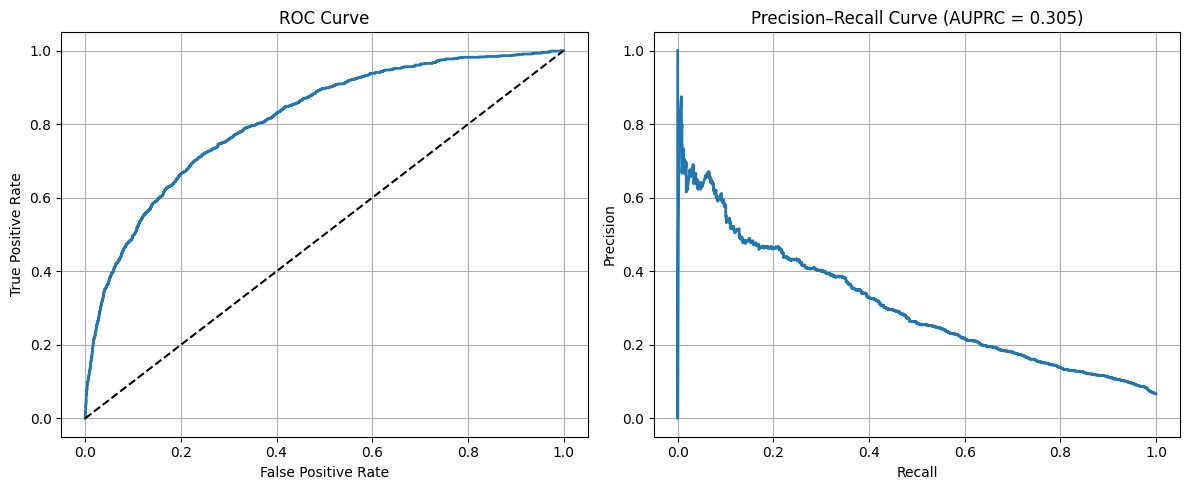

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

p = p_val
y = y_val

# ROC
fpr, tpr, _ = roc_curve(y, p)
auc_roc = roc_auc_score(y, p)

# PR
precision, recall, _ = precision_recall_curve(y, p)
auc_pr = average_precision_score(y, p)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC ---
axes[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}", linewidth=2)
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].grid(True)

# --- PR ---
axes[1].plot(recall, precision, linewidth=2)
axes[1].set_title(f"Precision–Recall Curve (AUPRC = {auc_pr:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid(True)

plt.tight_layout()
plt.show()


/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_71424/4246822761.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(p[y==0], label="Negatives", shade=True, bw_adjust=1.2)
/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_71424/4246822761.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(p[y==1], label="Positives", shade=True, bw_adjust=1.2, color="red")


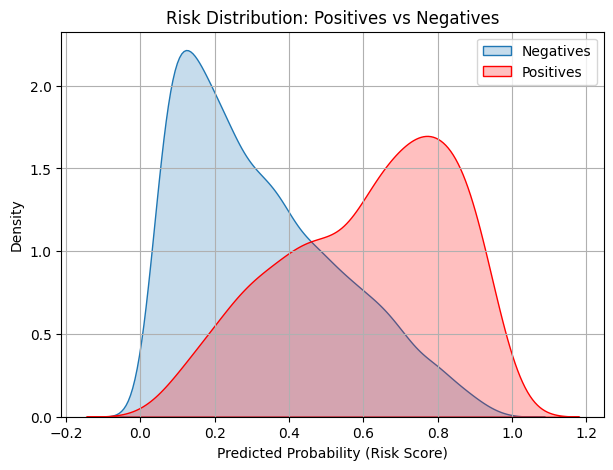

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose set
p = p_test   # or p_val
y = y_test   # or y_val

plt.figure(figsize=(7,5))

sns.kdeplot(p[y==0], label="Negatives", shade=True, bw_adjust=1.2)
sns.kdeplot(p[y==1], label="Positives", shade=True, bw_adjust=1.2, color="red")

plt.xlabel("Predicted Probability (Risk Score)")
plt.ylabel("Density")
plt.title("Risk Distribution: Positives vs Negatives")
plt.legend()
plt.grid(True)
plt.show()


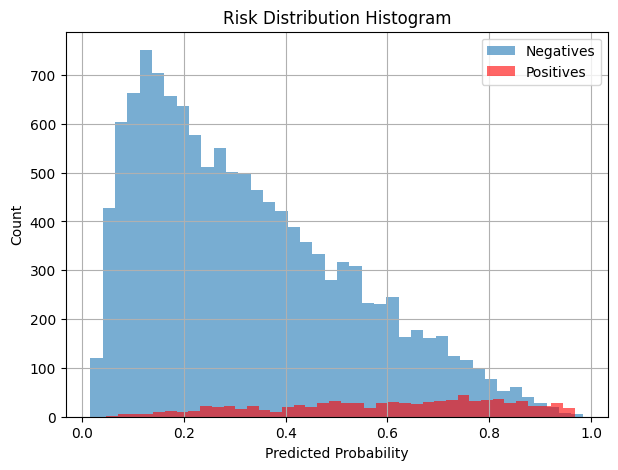

In [52]:
plt.figure(figsize=(7,5))

plt.hist(p[y==0], bins=40, alpha=0.6, label="Negatives")
plt.hist(p[y==1], bins=40, alpha=0.6, label="Positives", color="red")

plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Distribution Histogram")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
# Use validation or test set
X_for_shap = X_val_base   # or X_test_base

# Get SHAP values
shap_values = model.get_feature_importance(
    data=val_pool, 
    type="ShapValues"
)


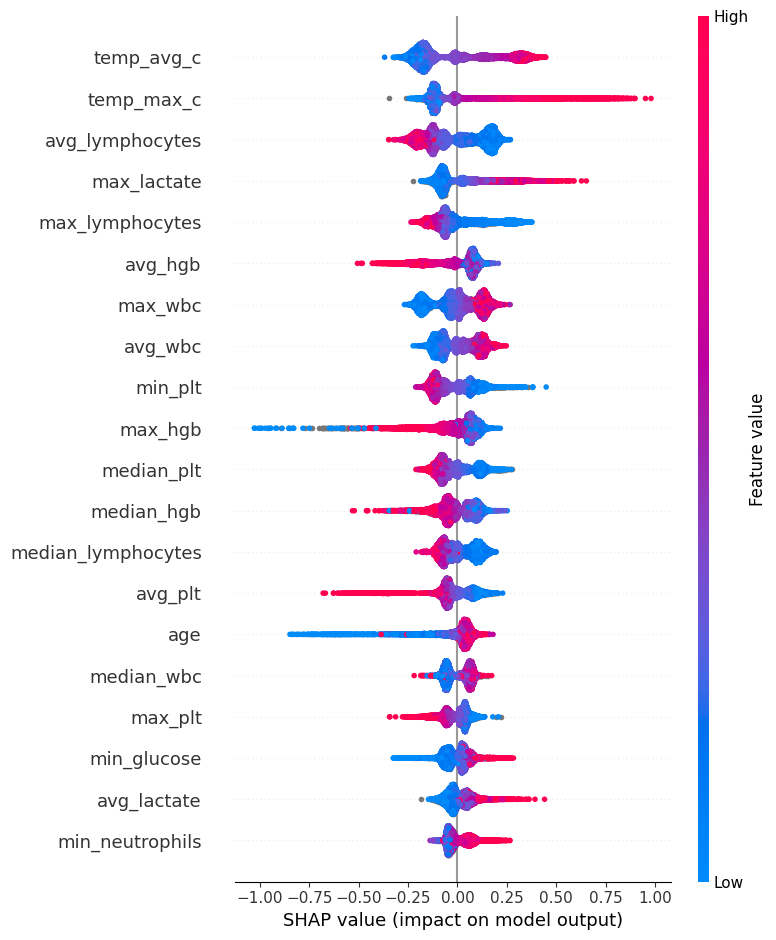

In [73]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP
explainer = shap.TreeExplainer(model)

# Compute shap_values for the matrix
shap_values = explainer.shap_values(X_for_shap)

# Summary plot
shap.summary_plot(shap_values, X_for_shap)


In [103]:
import shap
import numpy as np

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_base)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
ranking = sorted(zip(mean_abs_shap, X_train_base.columns), reverse=True)

for score, feat in ranking:
    print(f"{feat:25s}  {score:.4f}")
manual_cond = {
    "max_neutrophils": (">", 70),
    "temp_max_c":      (">", 38),
    "min_hgb":         ("<", 12),
    "min_plt":         ("<", 150),
    "has_any_line":    ("==", 1),
    "age":             (">", 65),
    "hr_max":          (">", 100),
    "sysbp_min":       ("<", 90),
    "max_lactate":     (">", 1.5),
    "avg_lymphocytes": ("<", 20),
    "max_glucose":     (">", 127),
    "max_wbc":         (">", 15),   # assumed fix for "mab_wbc"
}

temp_avg_c                 0.1858
temp_max_c                 0.1461
avg_lymphocytes            0.1331
max_lactate                0.1118
max_lymphocytes            0.1023
max_wbc                    0.0990
avg_hgb                    0.0954
avg_wbc                    0.0897
min_plt                    0.0873
max_hgb                    0.0867
median_plt                 0.0791
median_lymphocytes         0.0731
median_hgb                 0.0703
avg_plt                    0.0695
age                        0.0650
median_wbc                 0.0575
max_plt                    0.0519
min_glucose                0.0516
avg_lactate                0.0506
median_alc                 0.0462
hr_max                     0.0459
min_neutrophils            0.0457
min_hgb                    0.0448
spo2_min                   0.0438
min_lactate                0.0425
min_alc                    0.0422
min_wbc                    0.0368
bmi                        0.0365
spo2_avg                   0.0340
max_alc       

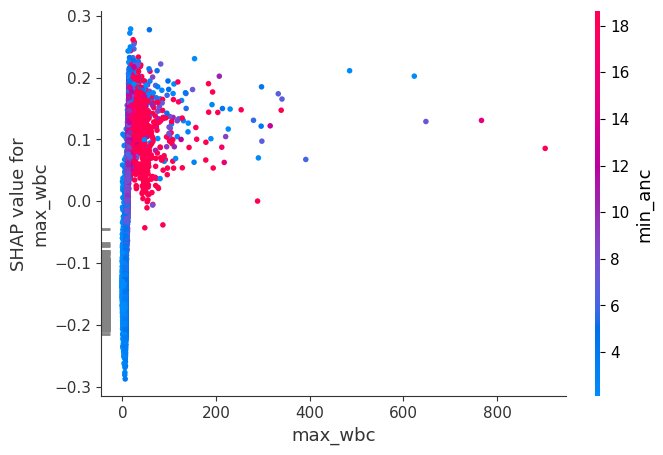

In [105]:
shap.dependence_plot("max_wbc", shap_values, X_train_base)


In [74]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve

# Use validation set for calibration
raw_p_val = model.predict_proba(X_val_base)[:, 1]

# Fit isotonic calibrator
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(raw_p_val, y_val)

# Apply calibrated probabilities
p_val_cal = iso.transform(raw_p_val)
p_test_cal = iso.transform(model.predict_proba(X_test_base)[:, 1])


In [75]:
fpr, tpr, thr = roc_curve(y_val, p_val_cal)
idx = (tpr >= 0.95).argmax()
thr_95_cal = thr[idx]

print("Calibrated threshold:", thr_95_cal)


Calibrated threshold: 0.0166358595194085


In [76]:
y_test_pred_95_cal = (p_test_cal >= thr_95_cal).astype(int)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_at_threshold(y_true, p_scores, threshold):
    """
    y_true   : array-like of shape (n_samples,) with 0/1 labels
    p_scores : array-like of shape (n_samples,) with predicted probabilities
    threshold: float, classify as positive if p >= threshold
    """
    y_pred = (p_scores >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total = tn + fp + fn + tp
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # recall for positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan   # recall for negatives
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan           # precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    
    # "Deferred rate" = proportion of sets you would *not* act on
    # i.e., predicted negatives (below threshold)
    n_deferred = tn + fn   # all predicted negatives
    deferred_rate = n_deferred / total
    
    results = {
        "threshold": threshold,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "total": total,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "PPV": ppv,
        "NPV": npv,
        "deferred_rate": deferred_rate,
        "n_deferred": n_deferred,
        "n_flagged": tp + fp,      # sets you would still do
    }
    return results



In [81]:
# Example usage on TEST set
metrics_test = evaluate_at_threshold(y_test, p_test, thr_95)
m=metrics_test
print("\n=== Performance at chosen threshold ===")
print(f"Threshold:            {m['threshold']:.4f}")
print(f"Sensitivity (Recall): {m['sensitivity']:.3f}")
print(f"Specificity:          {m['specificity']:.3f}")
print(f"PPV:                  {m['PPV']:.3f}")
print(f"NPV:                  {m['NPV']:.3f}")

print("\nCounts:")
print(f"TP: {m['TP']}  FP: {m['FP']}  TN: {m['TN']}  FN: {m['FN']}")

print("\nUtilization:")
print(f"Total sets:           {m['total']}")
print(f"Flagged (kept):       {m['n_flagged']} ({m['n_flagged']/m['total']:.1%})")
print(f"Deferred (avoided):   {m['n_deferred']} ({m['deferred_rate']:.1%})")
print(f"Missed positives (FN among deferred): {m['FN']} "
      f"({m['FN']/(m['TP']+m['FN']):.1%} of all positives)")



=== Performance at chosen threshold ===
Threshold:            0.1855
Sensitivity (Recall): 0.955
Specificity:          0.336
PPV:                  0.099
NPV:                  0.990

Counts:
TP: 1029  FP: 9354  TN: 4723  FN: 49

Utilization:
Total sets:           15155
Flagged (kept):       10383 (68.5%)
Deferred (avoided):   4772 (31.5%)
Missed positives (FN among deferred): 49 (4.5% of all positives)


In [79]:
metrics_test_cal = evaluate_at_threshold(y_test, p_test_cal, thr_95_cal)
m = metrics_test_cal

print("\n=== Performance at chosen threshold ===")
print(f"Threshold:            {m['threshold']:.4f}")
print(f"Sensitivity (Recall): {m['sensitivity']:.3f}")
print(f"Specificity:          {m['specificity']:.3f}")
print(f"PPV:                  {m['PPV']:.3f}")
print(f"NPV:                  {m['NPV']:.3f}")

print("\nCounts:")
print(f"TP: {m['TP']}  FP: {m['FP']}  TN: {m['TN']}  FN: {m['FN']}")

print("\nUtilization:")
print(f"Total sets:           {m['total']}")
print(f"Flagged (kept):       {m['n_flagged']} ({m['n_flagged']/m['total']:.1%})")
print(f"Deferred (avoided):   {m['n_deferred']} ({m['deferred_rate']:.1%})")
print(f"Missed positives (FN among deferred): {m['FN']} "
      f"({m['FN']/(m['TP']+m['FN']):.1%} of all positives)")



=== Performance at chosen threshold ===
Threshold:            0.0166
Sensitivity (Recall): 0.978
Specificity:          0.231
PPV:                  0.089
NPV:                  0.993

Counts:
TP: 1054  FP: 10831  TN: 3246  FN: 24

Utilization:
Total sets:           15155
Flagged (kept):       11885 (78.4%)
Deferred (avoided):   3270 (21.6%)
Missed positives (FN among deferred): 24 (2.2% of all positives)


In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# --- your manual cutpoints, cleaned ---
manual_cond = {
    "max_neutrophils": (">", 70),
    "temp_max_c":      (">", 38),
    "min_hgb":         ("<", 12),
    "min_plt":         ("<", 150),
    "has_any_line":    ("==", 1),
    "age":             (">", 65),
    "hr_max":          (">", 100),
    "sysbp_min":       ("<", 90),
    "max_lactate":     (">", 1.5),
    "min_lymphocytes": ("<", 20),
    "max_glucose":     (">", 127),
    "max_wbc":         (">", 15),   # assumed fix for "mab_wbc"
}

def build_rule_features(X, cond_dict, prefix="rule_"):
    """
    X: DataFrame with original features
    cond_dict: {col: (op, value)}
    returns: DataFrame with binary rule features
    """
    X_rules = pd.DataFrame(index=X.index)
    
    for col, (op, thresh) in cond_dict.items():
        if col not in X.columns:
            print(f"⚠️ WARNING: column {col} not found in X; skipping.")
            continue
        
        if op == ">":
            feat = (X[col] > thresh).astype(int)
        elif op == "<":
            feat = (X[col] < thresh).astype(int)
        elif op == "==":
            feat = (X[col] == thresh).astype(int)
        else:
            raise ValueError(f"Unsupported operator {op} for {col}")
        
        X_rules[prefix + col] = feat
    
    return X_rules

# build rule-feature matrices
X_train_rules = build_rule_features(X_train_base, manual_cond)
X_val_rules   = build_rule_features(X_val_base,   manual_cond)
X_test_rules  = build_rule_features(X_test_base,  manual_cond)

print("Rule feature columns:", list(X_train_rules.columns))
print("Shapes:", X_train_rules.shape, X_val_rules.shape, X_test_rules.shape)


Rule feature columns: ['rule_max_neutrophils', 'rule_temp_max_c', 'rule_min_hgb', 'rule_min_plt', 'rule_has_any_line', 'rule_age', 'rule_hr_max', 'rule_sysbp_min', 'rule_max_lactate', 'rule_min_lymphocytes', 'rule_max_glucose', 'rule_max_wbc']
Shapes: (73264, 12) (13417, 12) (15155, 12)


In [83]:
# logistic regression on the rule features
lr_rules = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    class_weight="balanced",  # you can drop this if you prefer no weighting
    max_iter=1000,
    random_state=42,
)

lr_rules.fit(X_train_rules, y_train)

# performance of the *logistic rule model*
p_val_rules  = lr_rules.predict_proba(X_val_rules)[:, 1]
p_test_rules = lr_rules.predict_proba(X_test_rules)[:, 1]

val_auc_rules  = roc_auc_score(y_val,  p_val_rules)
test_auc_rules = roc_auc_score(y_test, p_test_rules)

val_auprc_rules  = average_precision_score(y_val,  p_val_rules)
test_auprc_rules = average_precision_score(y_test, p_test_rules)

print(f"Rules-only logistic model - Val AUROC: {val_auc_rules:.3f}, AUPRC: {val_auprc_rules:.3f}")
print(f"Rules-only logistic model - Test AUROC: {test_auc_rules:.3f}, AUPRC: {test_auprc_rules:.3f}")


Rules-only logistic model - Val AUROC: 0.746, AUPRC: 0.192
Rules-only logistic model - Test AUROC: 0.747, AUPRC: 0.199


In [84]:
coef = lr_rules.coef_[0]     # shape (n_features,)
intercept = lr_rules.intercept_[0]
feature_names = X_train_rules.columns

# put into a DataFrame for inspection
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
}).sort_values("coef", ascending=False)

print(coef_df)


                 feature      coef
1        rule_temp_max_c  1.045235
3           rule_min_plt  0.628287
11          rule_max_wbc  0.570181
8       rule_max_lactate  0.566602
9   rule_min_lymphocytes  0.559889
2           rule_min_hgb  0.438773
4      rule_has_any_line  0.333990
7         rule_sysbp_min  0.323059
6            rule_hr_max  0.261466
5               rule_age  0.189958
10      rule_max_glucose  0.128724
0   rule_max_neutrophils  0.068586


In [87]:
# Choose a base to scale by: smallest non-zero abs coefficient
nonzero_abs = np.abs(coef[np.abs(coef) > 1e-6])
base = np.min(nonzero_abs)
print("Base coefficient for scaling:", base)

points = np.round(coef / base).astype(int)

points_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "points": points
}).sort_values("points", ascending=False)

print(points_df)


Base coefficient for scaling: 0.0685859083564257
                 feature      coef  points
1        rule_temp_max_c  1.045235      15
3           rule_min_plt  0.628287       9
11          rule_max_wbc  0.570181       8
9   rule_min_lymphocytes  0.559889       8
8       rule_max_lactate  0.566602       8
2           rule_min_hgb  0.438773       6
7         rule_sysbp_min  0.323059       5
4      rule_has_any_line  0.333990       5
6            rule_hr_max  0.261466       4
5               rule_age  0.189958       3
10      rule_max_glucose  0.128724       2
0   rule_max_neutrophils  0.068586       1


In [91]:
X_train_rules

,rule_max_neutrophils,rule_temp_max_c,rule_min_hgb,rule_min_plt,rule_has_any_line,rule_age,rule_hr_max,rule_sysbp_min,rule_max_lactate,rule_min_lymphocytes,rule_max_glucose,rule_max_wbc
1,1,1,1,1,0,1,0,0,1,1,1,1
2,0,0,0,0,0,1,1,0,0,1,0,0
5,1,0,0,0,0,0,1,0,0,1,1,0
6,0,0,1,1,0,0,0,0,0,0,1,0
7,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101829,1,0,0,0,0,1,1,0,1,1,1,0
101832,0,1,1,1,0,1,0,0,1,1,1,0
101833,0,0,1,0,0,1,0,0,0,1,1,0
101834,0,0,1,0,0,0,1,0,0,1,0,0


In [92]:

points_vec = (
    points_df.set_index("feature")
             .loc[X_train_rules.columns, "points"]   # or "points"
             .values
)
print("Points vector (aligned):", points_vec)


Points vector (aligned): [ 1 15  6  9  5  3  4  5  8  8  2  8]


In [93]:
import numpy as np

score_train = X_train_rules.values @ points_vec
score_val   = X_val_rules.values   @ points_vec
score_test  = X_test_rules.values  @ points_vec

print("Example test scores:", score_test[:10])
print("Score dtype:", score_test.dtype)


Example test scores: [13 19 30 18 25 27  0 35 25 27]
Score dtype: int64


In [95]:
from sklearn.metrics import confusion_matrix

def evaluate_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if tp+fp > 0 else 0
    npv = tn / (tn + fn) if tn+fn > 0 else 0
    
    total = len(y_true)
    flagged = tp + fp      # cultures you would DO
    deferred = tn + fn     # cultures you AVOID
    
    return {
        "thr": thr,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "PPV": ppv,
        "NPV": npv,
        "flagged_rate": flagged/total,
        "deferred_rate": deferred/total
    }


In [97]:
import numpy as np

best_thr = None
best_diff = 1e9

for thr in np.unique(score_val):
    m = evaluate_threshold(y_val, score_val, thr)
    diff = abs(m["sensitivity"] - 0.95)
    if diff < best_diff:
        best_diff = diff
        best_thr = thr

print("Best threshold for 95% sensitivity:", best_thr)


Best threshold for 95% sensitivity: 15


In [100]:
metrics_val  = evaluate_threshold(y_val,  score_val, best_thr)
metrics_test = evaluate_threshold(y_test, score_test, best_thr)


In [101]:
metrics_val

{'thr': np.int64(15),
 'TP': np.int64(854),
 'FP': np.int64(9308),
 'TN': np.int64(3213),
 'FN': np.int64(42),
 'sensitivity': np.float64(0.953125),
 'specificity': np.float64(0.25660889705295103),
 'PPV': np.float64(0.08403857508364496),
 'NPV': np.float64(0.9870967741935484),
 'flagged_rate': np.float64(0.7573973317433107),
 'deferred_rate': np.float64(0.24260266825668927)}

In [102]:
metrics_test

{'thr': np.int64(15),
 'TP': np.int64(1037),
 'FP': np.int64(10637),
 'TN': np.int64(3440),
 'FN': np.int64(41),
 'sensitivity': np.float64(0.9619666048237476),
 'specificity': np.float64(0.24437024934289978),
 'PPV': np.float64(0.08882987836217235),
 'NPV': np.float64(0.9882217753519104),
 'flagged_rate': np.float64(0.7703068294292312),
 'deferred_rate': np.float64(0.2296931705707687)}